In [1]:
import os
import math
import cv2 as cv
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


Loaded 2219 images


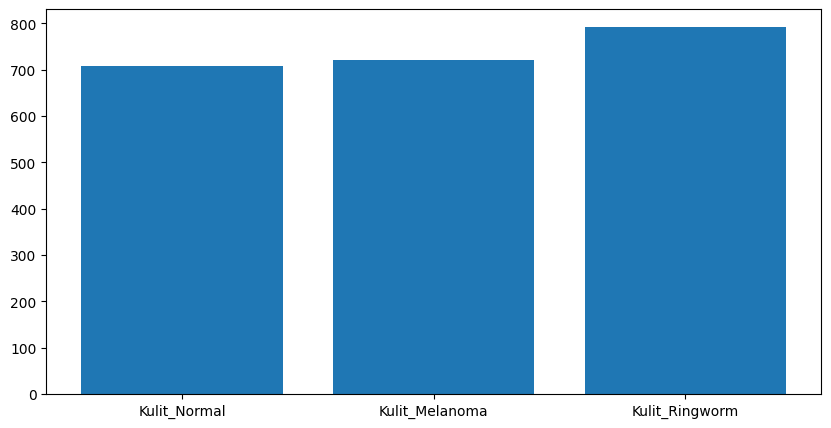

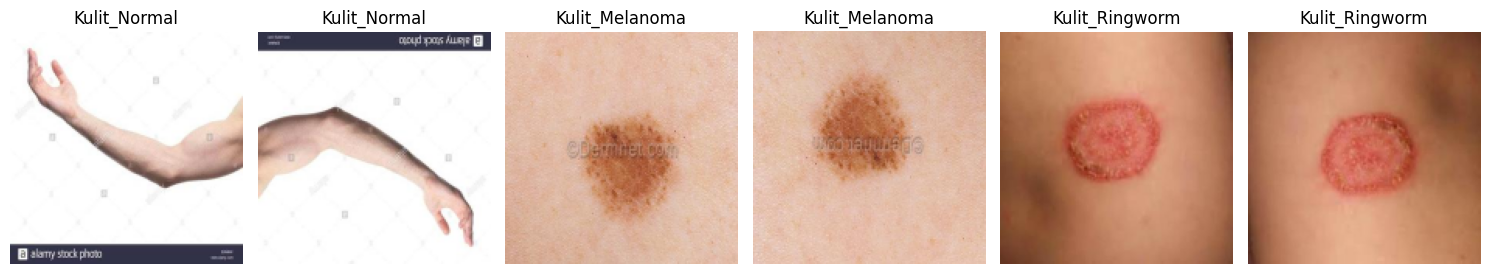

In [2]:
def load(folders):
    target_size = (150, 150)
    sample_count = 2
    images = []
    labels = []
    count = {}
    sample = {folder: [] for folder in folders} 
    
    for folder_path in folders:
        folder_name = os.path.basename(folder_path)
        count[folder_name] = 0
        
        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)
            img = cv.imread(img_path)
            if img is not None:
                img = cv.resize(img, target_size)
                images.append(img)
                label = folder_name  
                labels.append(label)
                
                count[folder_name] += 1
                
                if len(sample[folder_name]) < sample_count: 
                    sample[folder_name].append(img)
    
    return images, labels, count, sample

f1 = 'Kulit_Normal'
f2 = 'Kulit_Melanoma'
f3 = 'Kulit_Ringworm'


images, labels, count, sample = load([f1, f2, f3])


print(f"Loaded {len(images)} images")

plt.figure(figsize=(10, 5))
plt.bar(count.keys(), count.values())
plt.show()


fig, axs = plt.subplots(1, len([f1, f2, f3]) * 2, figsize=(15, 5))
axs = axs.flatten()
for i, folder in enumerate([f1, f2, f3]):
    for j in range(2):
        index = i * 2 + j
        if j < len(sample[folder]):
            axs[index].imshow(cv.cvtColor(sample[folder][j], cv.COLOR_BGR2RGB))
            axs[index].set_title(f"{folder}")   
        axs[index].axis('off')

plt.tight_layout()
plt.show()

<Figure size 1600x800 with 0 Axes>

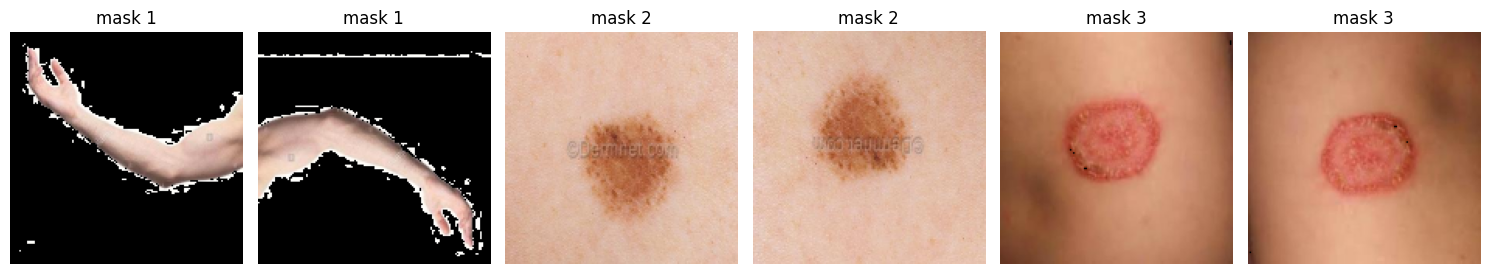

In [3]:
def masking(images):
    skin_images = []

    for image in images:
        R_Frame = image[:, :, 2]
        G_Frame = image[:, :, 1]
        B_Frame = image[:, :, 0]
        BRG_Max = np.maximum.reduce([B_Frame, G_Frame, R_Frame])
        BRG_Min = np.minimum.reduce([B_Frame, G_Frame, R_Frame])
        Rule_1 = np.logical_and.reduce([
            R_Frame > 50, 
            G_Frame > 40, 
            B_Frame > 20, 
            BRG_Max - BRG_Min > 13, 
            np.abs(R_Frame - G_Frame) > 10, 
            R_Frame > G_Frame, 
            R_Frame > B_Frame
        ])
        Rule_2 = np.logical_and.reduce([
            R_Frame > 220, 
            G_Frame > 210, 
            B_Frame > 170, 
            np.abs(R_Frame - G_Frame) <= 15, 
            R_Frame > B_Frame, 
            G_Frame > B_Frame
        ])
        mask = np.logical_or(Rule_1, Rule_2)
        mask = mask.astype(np.uint8) * 255

        skin = cv.bitwise_and(image, image, mask=mask)

        skin_images.append(skin)

    return np.array(skin_images)

mask1 = masking([img for img, label in zip(images, labels) if label == f1])
mask2 = masking([img for img, label in zip(images, labels) if label == f2])
mask3 = masking([img for img, label in zip(images, labels) if label == f3])

plt.figure(figsize=(16, 8))
fig, axs = plt.subplots(1, len([mask1, mask2, mask3]) * 2, figsize=(15, 5))
axs = axs.flatten()
sample = [mask1, mask2, mask3]

for i, folder in enumerate(sample):
    for j in range(2):
        index = i * 2 + j
        if j < len(folder):
            axs[index].imshow(cv.cvtColor(folder[j], cv.COLOR_BGR2RGB))
            axs[index].set_title(f"mask {i + 1}")
        axs[index].axis('off')

plt.tight_layout()
plt.show()

In [4]:
def togray(image):
    kernelgauss = np.ones((3,3))/9
    imagel = image[:,:,2]  
    image0 = image[:,:,0]  
    image2 = image[:,:,1]  

    filteredimage0 = cv.filter2D(image0, -1, kernelgauss)
    filteredimagel = cv.filter2D(imagel, -1, kernelgauss)
    filteredimage2 = cv.filter2D(image2, -1, kernelgauss)

    return filteredimage0/3 + filteredimagel/3 + filteredimage2 / 3 

In [5]:
def threshold(image):
    nilai = 128
    image[image >= nilai] = 128
    image[image < nilai] = 255
    return image

In [6]:
kernel = np.array([[0, 0, 1, 0, 0],
                   [0, 1, 1, 1, 0],
                   [1, 1, 1, 1, 1],
                   [0, 1, 1, 1, 0],
                   [0, 0, 1, 0, 0]])

In [7]:

def dilasi(image, kernel):
    padh, padw = kernel.shape[0] // 2, kernel.shape[1] // 2
    padimg = np.pad(image, ((padh, padh), (padw, padw)), mode='constant', constant_values=0)
    result = np.zeros_like(image, dtype=np.uint8)
    
    for i in range(padh, padimg.shape[0] - padh):
        for j in range(padw, padimg.shape[1] - padw):
            if np.any(padimg[i - padh:i + padh + 1, j - padw:j + padw + 1][kernel == 1] == 255):
                result[i - padh, j - padw] = 255
                
    return result

In [8]:

def erosi(image, kernel):
    padh, padw = kernel.shape[0] // 2, kernel.shape[1] // 2
    padimg = np.pad(image, ((padh, padh), (padw, padw)), mode='constant', constant_values=255)
    result = np.zeros_like(image, dtype=np.uint8)
    
    for i in range(padh, padimg.shape[0] - padh):
        for j in range(padw, padimg.shape[1] - padw):
            if np.all(padimg[i - padh:i + padh + 1, j - padw:j + padw + 1][kernel == 1] == 255):
                result[i - padh, j - padw] = 255
                
    return result

In [9]:
def preprocessingclosing(images):
    preproses = []
    for img in images:
        gray_img = togray(img)
        threshold_img = threshold(gray_img)
        dilasi_img = dilasi(threshold_img, kernel)
        opening_img = erosi(dilasi_img, kernel)
        preproses.append(opening_img)
    return preproses

pro1 = preprocessingclosing(mask1)
pro2 = preprocessingclosing(mask2)
pro3 = preprocessingclosing(mask3)

In [10]:
def derajat(img, angle):
    max_val = np.max(img)
    temp = np.zeros([max_val + 1, max_val + 1])
    
    if angle == 0:
        for i in range(len(img)):
            for j in range(len(img[i]) - 1):
                temp[img[i, j], img[i, j + 1]] += 1
    elif angle == 45:
        for i in range(len(img) - 1):
            for j in range(len(img[i]) - 1):
                temp[img[i + 1, j], img[i, j + 1]] += 1
    elif angle == 90:
        for i in range(len(img) - 1):
            for j in range(len(img[i]) - 1):
                temp[img[i + 1, j], img[i, j]] += 1
    elif angle == 135:
        for i in range(len(img) - 1):
            for j in range(len(img[i]) - 1):
                temp[img[i, j], img[i + 1, j + 1]] += 1
    
    data = temp + temp.T
    data /= np.sum(data)
    
    return data

def gabung(image):
    features = []
    angles = [0, 45, 90, 135]
    
    for img in image:
        data = []
        for angle in angles:
            data.append(derajat(img, angle))
        features.append(data)
        
    return features

def hitung(data):
    features = {}
    features['kontras'] = sum(x * pow(i - j, 2) for i, row in enumerate(data) for j, x in enumerate(row))
    features['dissimilarity'] = sum(abs(i - j) * x for i, row in enumerate(data) for j, x in enumerate(row))
    features['homogenitas'] = sum(x / (1 + pow(i - j, 2)) for i, row in enumerate(data) for j, x in enumerate(row))
    features['entropy'] = -sum(x * math.log(x) for row in data for x in row if x > 0.0)
    features['energy'] = sum(x ** 2 for row in data for x in row) 
    features['asm'] = sum(x ** 2 for row in data for x in row) 
    features['korelasi'] = korelasi(data)
    return features

def korelasi(data):
    jumlahBaris = len(data)
    jumlahKolom = len(data[0])
    sumIJ = sum(i * j * data[i][j] for i in range(jumlahBaris) for j in range(jumlahKolom))
    sumI = sum(i * data[i][j] for i in range(jumlahBaris) for j in range(jumlahKolom))
    sumJ = sum(j * data[i][j] for i in range(jumlahBaris) for j in range(jumlahKolom))
    sumI_squared = sum((i - sumI) ** 2 * data[i][j] for i in range(jumlahBaris) for j in range(jumlahKolom))
    sumJ_squared = sum((j - sumJ) ** 2 * data[i][j] for i in range(jumlahBaris) for j in range(jumlahKolom))

    std_i = math.sqrt(sumI_squared)
    std_j = math.sqrt(sumJ_squared)

    if std_i != 0 and std_j != 0:
        kor = (sumIJ - sumI * sumJ) / (std_i * std_j)
    else:
        kor = 0

    return kor

def ekstraksi(data, label):
    features = gabung(data)
    angles = ['0', '45', '90', '135']
    result = []
    n = 1000

    for j in tqdm(range(min(len(features), n)), desc=f'Ekstraksi fitur untuk {label}'):
        eksfitur = [label] 

        for i in features[j]:
            feature_values = hitung(i)
            eksfitur.append(feature_values['kontras'])
            eksfitur.append(feature_values['dissimilarity'])
            eksfitur.append(feature_values['homogenitas'])
            eksfitur.append(feature_values['entropy'])
            eksfitur.append(feature_values['energy'])  
            eksfitur.append(feature_values['asm']) 
            eksfitur.append(feature_values['korelasi'])

        result.append(eksfitur)

    headers = ['path']
    for angle in angles:
        headers.extend([f'kontras{angle}', f'dissimilarity{angle}', f'homogenitas{angle}', f'entropi{angle}', f'asm{angle}', f'energi{angle}', f'correlation{angle}'])

    df = pd.DataFrame(result, columns=headers)

    csv_path = f'result_csv/Setelah Preprocessing pada_{label}.csv'
    df.to_csv(csv_path, index=False)
    return df
ekstraksi(pro1, 'Kulit_Normal')


Ekstraksi fitur untuk normal: 100%|██████████| 707/707 [07:53<00:00,  1.49it/s]


,path,kontras0,dissimilarity0,homogenitas0,entropi0,asm0,energi0,correlation0,kontras45,dissimilarity45,...,asm90,energi90,correlation90,kontras135,dissimilarity135,homogenitas135,entropi135,asm135,energi135,correlation135
0,normal,744.805369,2.920805,0.988546,0.495911,0.722073,0.722073,0.957037,1376.593397,5.398405,...,0.718356,0.718356,0.943617,913.823702,3.583622,0.985947,0.508183,0.718090,0.718090,0.947573
1,normal,712.802013,2.795302,0.989038,0.488853,0.726576,0.726576,0.958253,1326.801721,5.203144,...,0.720396,0.720396,0.944975,869.889870,3.411333,0.986622,0.500472,0.722783,0.722783,0.949330
2,normal,706.983221,2.772483,0.989128,0.487554,0.727404,0.727404,0.958477,869.889870,3.411333,...,0.723617,0.723617,0.944298,1320.943876,5.180172,0.979686,0.525465,0.716823,0.716823,0.922840
3,normal,672.070470,2.635570,0.989665,0.481966,0.730592,0.730592,0.960122,846.458493,3.319445,...,0.724529,0.724529,0.947368,1262.365434,4.950453,0.980587,0.518871,0.720361,0.720361,0.925505
4,normal,706.983221,2.772483,0.989128,0.487554,0.727404,0.727404,0.958477,869.889870,3.411333,...,0.723617,0.723617,0.944298,1320.943876,5.180172,0.979686,0.525465,0.716823,0.716823,0.922840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
702,normal,744.805369,2.920805,0.988546,0.450417,0.757829,0.757829,0.950382,1241.862979,4.870051,...,0.757854,0.757854,0.956540,896.250169,3.514707,0.986217,0.461350,0.754249,0.754249,0.940630
703,normal,744.805369,2.920805,0.988546,0.450246,0.757960,0.757960,0.950354,1241.862979,4.870051,...,0.757986,0.757986,0.956515,896.250169,3.514707,0.986217,0.461177,0.754380,0.754380,0.940597
704,normal,744.805369,2.920805,0.988546,0.450417,0.757829,0.757829,0.950382,1241.862979,4.870051,...,0.757854,0.757854,0.956540,896.250169,3.514707,0.986217,0.461350,0.754249,0.754249,0.940630
705,normal,576.060403,2.259060,0.991141,0.430002,0.767708,0.767708,0.960364,779.093284,3.055268,...,0.762181,0.762181,0.943194,943.112923,3.698482,0.985496,0.454442,0.760917,0.760917,0.935478


In [11]:
ekskulit1 = ekstraksi(pro1, 'Kulit_Normal')
ekskulit2 = ekstraksi(pro2, 'Kulit_Melanoma')
ekskulit3 = ekstraksi(pro3, 'Kulit_Ringworm')

Ekstraksi fitur untuk Kulit_Ringworm: 100%|██████████| 791/791 [08:36<00:00,  1.53it/s]


In [12]:
def seleksi(dataframe, threshold=0.5):
    numdata = dataframe.drop(columns=['path'])
    corelasi = numdata.corr().abs()
    upper = corelasi.where(np.triu(np.ones(corelasi.shape), k=1).astype(bool))
    kedrop = [column for column in upper.columns if any(upper[column] > threshold)]
    return dataframe.drop(kedrop, axis=1)

dataframes = [ekskulit1, ekskulit2, ekskulit3]
seleksif1, seleksif2, seleksif3 = map(seleksi, dataframes)

print([seleksif1, seleksif2, seleksif3])

[             path    kontras0  correlation0
0    Kulit_Normal  744.805369      0.957037
1    Kulit_Normal  712.802013      0.958253
2    Kulit_Normal  706.983221      0.958477
3    Kulit_Normal  672.070470      0.960122
4    Kulit_Normal  706.983221      0.958477
..            ...         ...           ...
702  Kulit_Normal  744.805369      0.950382
703  Kulit_Normal  744.805369      0.950354
704  Kulit_Normal  744.805369      0.950382
705  Kulit_Normal  576.060403      0.960364
706  Kulit_Normal  608.063758      0.958720

[707 rows x 3 columns],                path    kontras0
0    Kulit_Melanoma  395.677852
1    Kulit_Melanoma  424.771812
2    Kulit_Melanoma  413.134228
3    Kulit_Melanoma  401.496644
4    Kulit_Melanoma  413.134228
..              ...         ...
716  Kulit_Melanoma    0.000000
717  Kulit_Melanoma    0.000000
718  Kulit_Melanoma    0.000000
719  Kulit_Melanoma    0.000000
720  Kulit_Melanoma    0.000000

[721 rows x 2 columns],                path     kontras0
0   

In [13]:
def split_data(X, y, test_size=0.3, random_state=None):
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

dataframes = [seleksif1, seleksif2, seleksif3]
all_data = pd.concat(dataframes, ignore_index=True)
X = all_data.drop(columns=['path']).values
y = all_data['path'].values
train_test_ratio = 0.7
test_size = 1 - train_test_ratio

X_train, X_test, y_train, y_test = split_data(X, y, test_size=test_size)

print("Jumlah data training:", len(X_train))
print("Jumlah data testing:", len(X_test))

Jumlah data training: 1553
Jumlah data testing: 666


In [14]:
scaler = StandardScaler()
imputer = SimpleImputer(strategy='mean')
XTrainImputed = imputer.fit_transform(X_train)
XTestImputed = imputer.transform(X_test)
XTrainNorm = scaler.fit_transform(XTrainImputed)
XTestNorm = scaler.transform(XTestImputed)

In [15]:
k = 5
knn_model = KNeighborsClassifier(n_neighbors=k)
knn_model.fit(XTrainNorm, y_train)
y_pred_knn = knn_model.predict(XTestNorm)

svc_model = SVC()
svc_model.fit(XTrainNorm, y_train)
y_pred_svc = svc_model.predict(XTestNorm)

rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(XTrainNorm, y_train)
y_pred_rf = rf_model.predict(XTestNorm)

In [16]:
def evaluasi(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    return accuracy, precision, recall, f1

akurasiknn, presisiknn, recalknn, f1knn = evaluasi(y_test, y_pred_knn)
akurasisvc, presisisvc, recalsvc, f1svc = evaluasi(y_test, y_pred_svc)
akurasirf, presisirf, recalrf, f1rf = evaluasi(y_test, y_pred_rf)
print(f"Akurasi KNN : {akurasiknn * 100:.2f}%")
print(f"Akurasi SVC  : {akurasisvc * 100:.2f}%")
print(f"Akurasi RF  : {akurasirf * 100:.2f}%")

Akurasi KNN : 72.67%
Akurasi SVC  : 67.42%
Akurasi RF  : 71.62%


 ┌──────────┬────────────┬────────────┬────────────┬────────────┐
 |          │ Accuracy   │ Precision  │ Recall     │ F1 Score   |
 ├──────────┼────────────┼────────────┼────────────┼────────────┤
 |KNN       │ 0.72672673 │ 0.72925765 │ 0.72672673 │ 0.72795497 |
 ├──────────┼────────────┼────────────┼────────────┼────────────┤
 |SVC       │ 0.67417417 │ 0.70882187 │ 0.67417417 │ 0.65385782 |
 ├──────────┼────────────┼────────────┼────────────┼────────────┤
 |RF        │ 0.71621622 │ 0.71667082 │ 0.71621622 │ 0.71642933 |
 └──────────┴────────────┴────────────┴────────────┴────────────┘


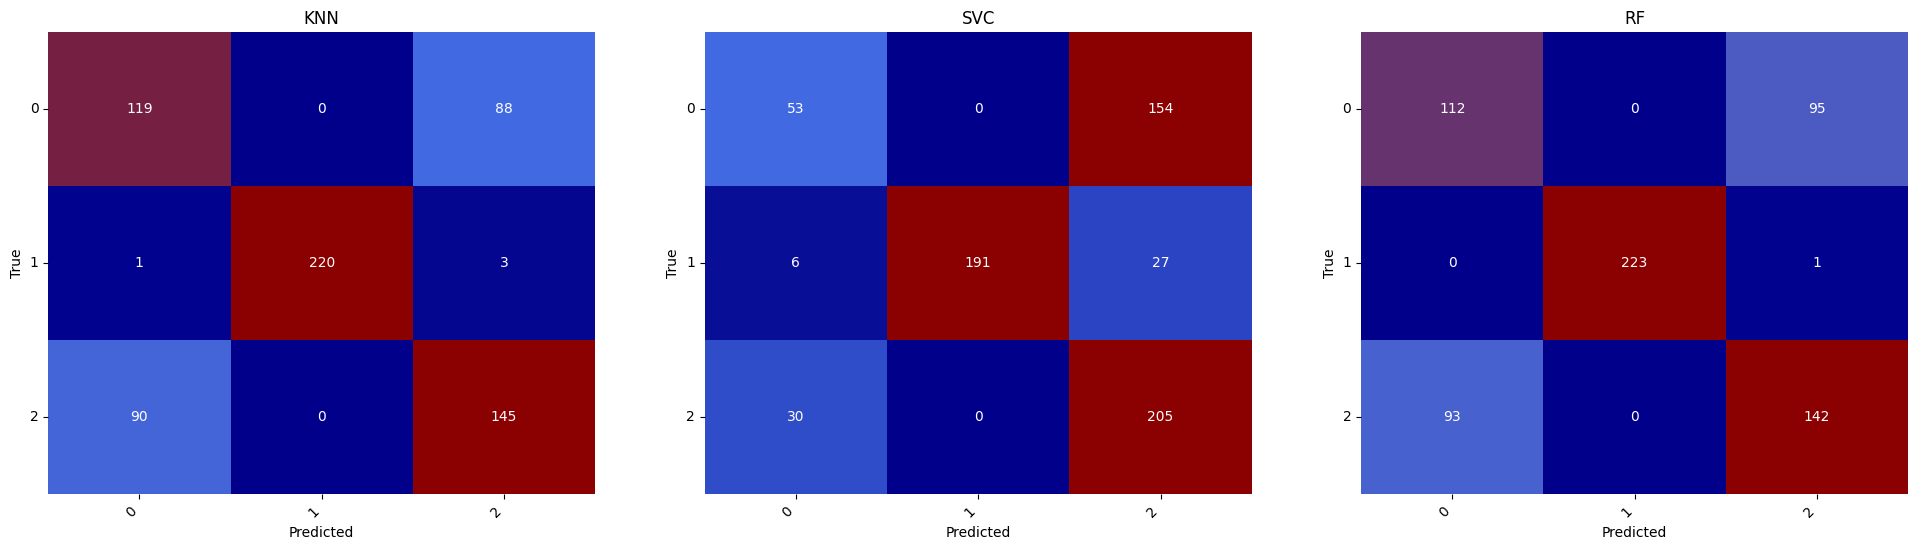

In [17]:
header = f"{' |':<10}  │ {'Accuracy':<10} │ {'Precision':<10} │ {'Recall':<10} │ {'F1 Score':<10} |"
separator = "─" * 62

top_border = f" ┌{'─' * 10}┬{'─' * 12}┬{'─' * 12}┬{'─' * 12}┬{'─' * 12}┐"
mid_border = f" ├{'─' * 10}┼{'─' * 12}┼{'─' * 12}┼{'─' * 12}┼{'─' * 12}┤"
bottom_border = f" └{'─' * 10}┴{'─' * 12}┴{'─' * 12}┴{'─' * 12}┴{'─' * 12}┘"

row_knn = f"{' |KNN':<10}  │ {akurasiknn:<10.8f} │ {presisiknn:<10.8f} │ {recalknn:<10.8f} │ {f1knn:<10.8f} |"
row_svc = f"{' |SVC':<10}  │ {akurasisvc:<10.8f} │ {presisisvc:<10.8f} │ {recalsvc:<10.8f} │ {f1svc:<10.8f} |"
row_rf = f"{' |RF':<10}  │ {akurasirf:<10.8f} │ {presisirf:<10.8f} │ {recalrf:<10.8f} │ {f1rf:<10.8f} |"

print(top_border)
print(header)
print(mid_border)
print(row_knn)
print(mid_border)
print(row_svc)
print(mid_border)
print(row_rf)
print(bottom_border)

colors = ["#00008B", "#4169E1", "#4169E1", "#8B0000", "#8B0000", "#8B0000"]
cmap = LinearSegmentedColormap.from_list("color", colors, N=256)

plt.figure(figsize=(24, 6), facecolor='None')

plt.subplot(1, 3, 1)
cm_knn = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm_knn, annot=True, cmap=cmap, vmin=0, vmax=np.max(cm_knn), fmt='d', cbar=False)
plt.title('KNN')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.subplot(1, 3, 2)
cm_svc = confusion_matrix(y_test, y_pred_svc)
sns.heatmap(cm_svc, annot=True, cmap=cmap, vmin=0, vmax=np.max(cm_svc), fmt='d', cbar=False)
plt.title('SVC')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.subplot(1, 3, 3)
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, cmap=cmap, vmin=0, vmax=np.max(cm_rf), fmt='d', cbar=False)
plt.title('RF')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.show()